# 01 – EDA Olist

## 1. Setup
- import de bibliotecas (pandas, matplotlib, seaborn, plotly)
- carregar variáveis de ambiente e conectar no Postgres

## 2. Carregamento dos dados
- `SELECT * FROM bronze.orders LIMIT 1000`
- trazer também customers, order_items, …

## 3. Estatísticas Descritivas
- `df.describe()` por tabela
- contagem de nulos / completude

## 4. Distribuições e Outliers
- histograma de order_value, freight_value
- boxplot por estado, categoria de produto

## 5. Análise de Tempo
- séries de pedidos por dia/mês
- tempo entre pedido e entrega

## 6. Correlações
- correlação entre price e freight_value
- heatmap

## 7. Conclusões iniciais
- principais insights para modelagem


In [3]:
# Ajusta o path para apontar à raiz do projeto (/app) dentro do container
import sys, os
sys.path.insert(0, os.path.abspath('..'))


## 1. Setup

In [13]:
import os
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from src.utils.config import settings

# Conexão ao Postgres
engine = sa.create_engine(
    f"postgresql+psycopg://{settings.PG_USER}:"
    f"{settings.PG_PASSWORD}@{settings.PG_HOST}:"
    f"{settings.PG_PORT}/{settings.PG_DB}"
)

# Teste rápido: traga as 5 primeiras linhas de bronze.orders
df = pd.read_sql("SELECT * FROM bronze.orders LIMIT 5", engine)
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


## 2. Carregamento completo dos dados

In [5]:
df_orders      = pd.read_sql("SELECT * FROM bronze.orders", engine)
df_customers   = pd.read_sql("SELECT * FROM bronze.customers", engine)
df_items       = pd.read_sql("SELECT * FROM bronze.order_items", engine)
df_payments    = pd.read_sql("SELECT * FROM bronze.order_payments", engine)
df_reviews     = pd.read_sql("SELECT * FROM bronze.order_reviews", engine)
df_products    = pd.read_sql("SELECT * FROM bronze.products", engine)
df_sellers     = pd.read_sql("SELECT * FROM bronze.sellers", engine)
df_geoloc      = pd.read_sql("SELECT * FROM bronze.geolocation", engine)

# Mostra quantas linhas cada tabela trouxe
print("orders     :", df_orders.shape)
print("customers  :", df_customers.shape)
print("order_items:", df_items.shape)
print("payments   :", df_payments.shape)
print("reviews    :", df_reviews.shape)
print("products   :", df_products.shape)
print("sellers    :", df_sellers.shape)
print("geolocation:", df_geoloc.shape)


orders     : (99441, 8)
customers  : (99441, 5)
order_items: (112650, 7)
payments   : (103886, 5)
reviews    : (99224, 7)
products   : (32951, 9)
sellers    : (3095, 4)
geolocation: (1000163, 5)


## 3. Estatísticas Descritivas

In [6]:
# Descritivas de orders
display(df_orders.describe())

# % de valores nulos em orders
pct_null_orders = df_orders.isna().mean().round(4) * 100
print("Nulos (%) em orders:\n", pct_null_orders, "\n")

# Descritivas e nulos das principais colunas de interesse
# (repita para as outras tabelas conforme necessário)
display(df_payments.describe())
pct_null_payments = df_payments.isna().mean().round(4) * 100
print("Nulos (%) em payments:\n", pct_null_payments)


,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


Nulos (%) em orders:
 order_id                         0.00
customer_id                      0.00
order_status                     0.00
order_purchase_timestamp         0.00
order_approved_at                0.16
order_delivered_carrier_date     1.79
order_delivered_customer_date    2.98
order_estimated_delivery_date    0.00
dtype: float64 



,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


Nulos (%) em payments:
 order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64


## 4. Distribuições e Outliers

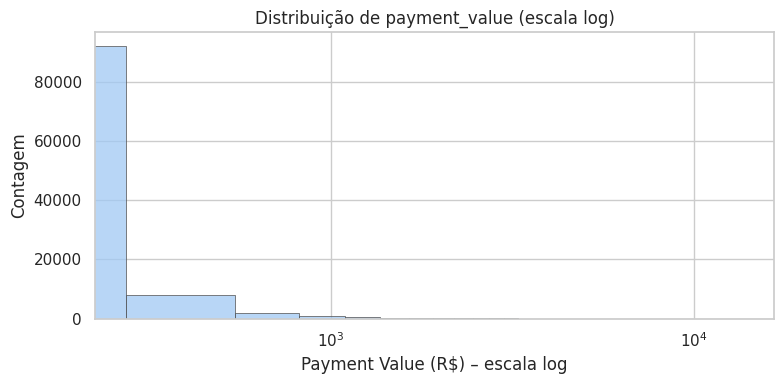

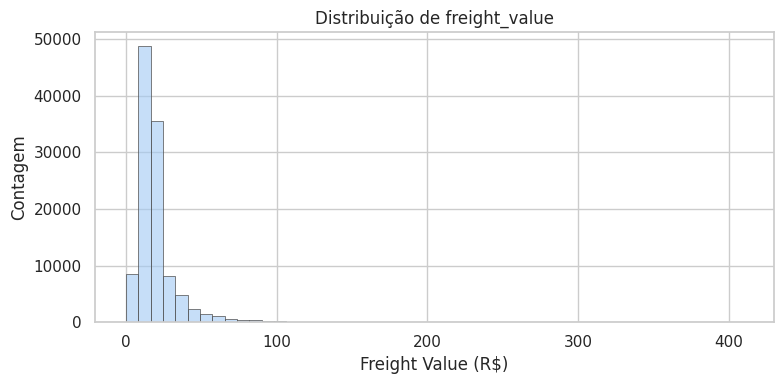

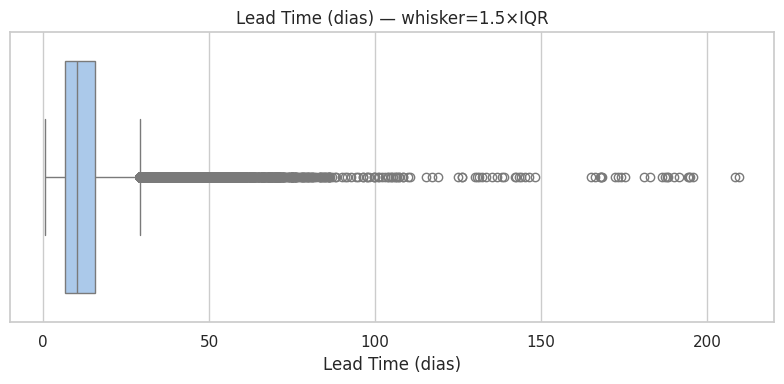

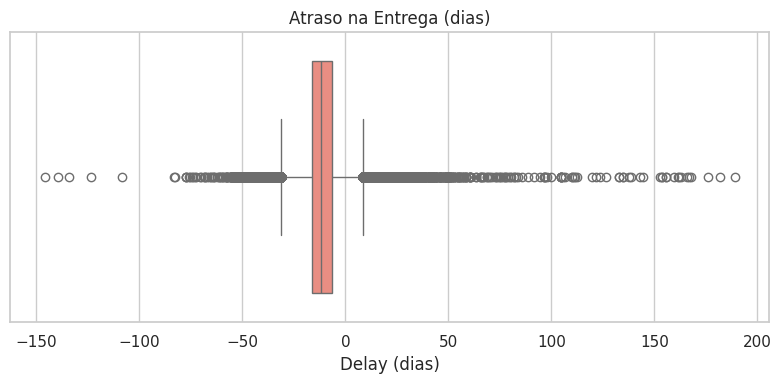

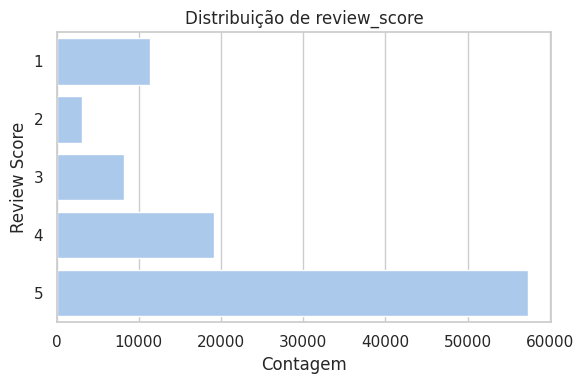

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tema e paleta
sns.set_theme(style="whitegrid", palette="pastel")

# 1) Histograma de payment_value (escala logarítmica)
plt.figure(figsize=(8, 4))
sns.histplot(
    df_payments['payment_value'],
    bins=50,
    kde=False,
    edgecolor=".3",
    linewidth=.5
)
plt.xscale('log')
plt.title("Distribuição de payment_value (escala log)")
plt.xlabel("Payment Value (R$) – escala log")
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

# 2) Histograma de freight_value
plt.figure(figsize=(8, 4))
sns.histplot(
    df_items['freight_value'],
    bins=50,
    alpha=0.6,
    edgecolor=".3",
    linewidth=.5
)
plt.title("Distribuição de freight_value")
plt.xlabel("Freight Value (R$)")
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

# 3) Boxplot de lead time (entrega – compra) com whisker 1.5×IQR
df_orders['lead_time_days'] = (
    df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']
).dt.total_seconds() / (24*3600)

plt.figure(figsize=(8, 4))
sns.boxplot(
    x=df_orders['lead_time_days'],
    whis=1.5
)
plt.title("Lead Time (dias) — whisker=1.5×IQR")
plt.xlabel("Lead Time (dias)")
plt.tight_layout()
plt.show()

# 4) Boxplot de atraso na entrega (real – estimado)
df_orders['delay_days'] = (
    df_orders['order_delivered_customer_date'] - df_orders['order_estimated_delivery_date']
).dt.total_seconds() / (24*3600)

plt.figure(figsize=(8, 4))
sns.boxplot(
    x=df_orders['delay_days'],
    color="salmon",
    whis=1.5
)
plt.title("Atraso na Entrega (dias)")
plt.xlabel("Delay (dias)")
plt.tight_layout()
plt.show()

# 5) Distribuição de review_score (barras horizontais)
plt.figure(figsize=(6, 4))
sns.countplot(
    y=df_reviews['review_score'],
    orient="h"
)
plt.title("Distribuição de review_score")
plt.xlabel("Contagem")
plt.ylabel("Review Score")
plt.tight_layout()
plt.show()


## 5. Análise Temporal

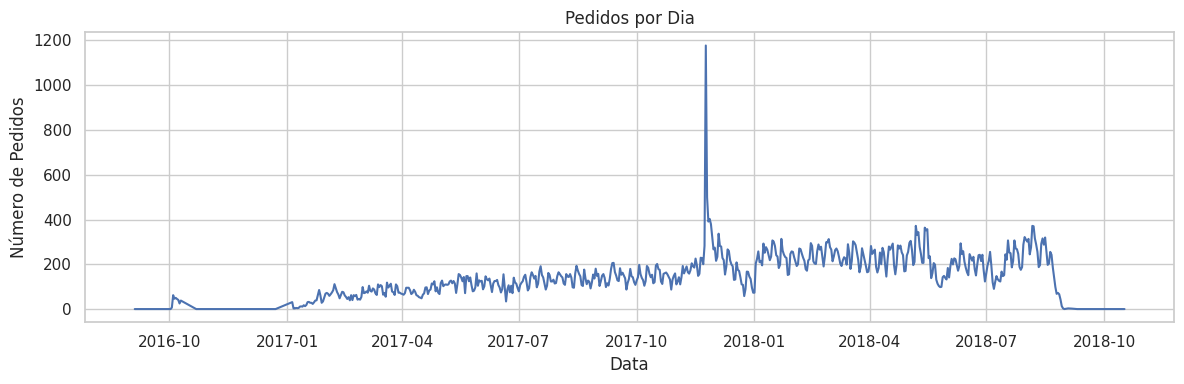

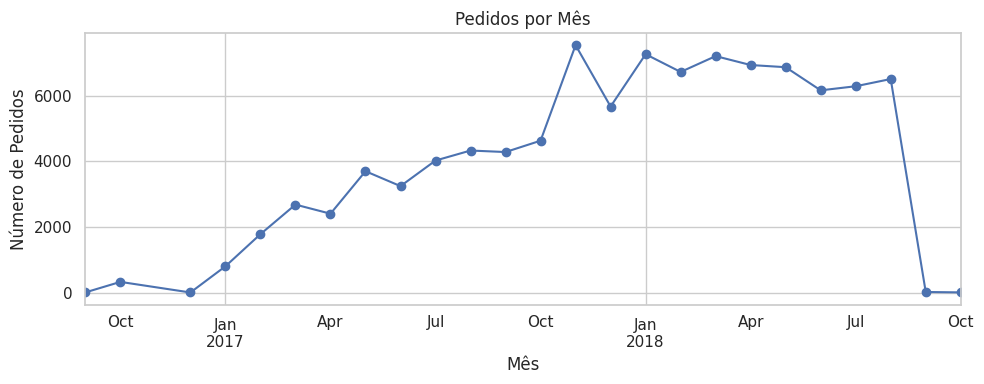

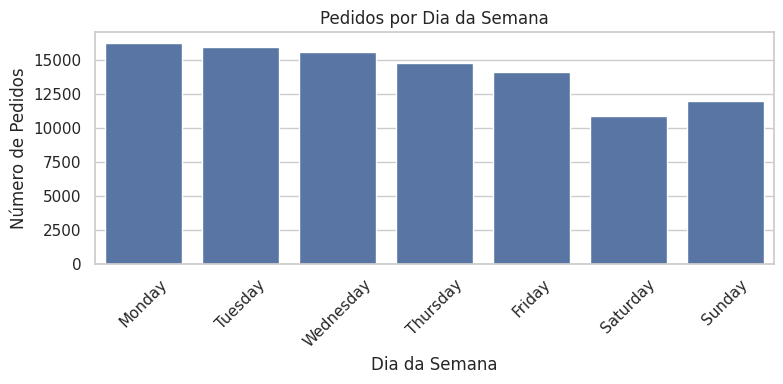

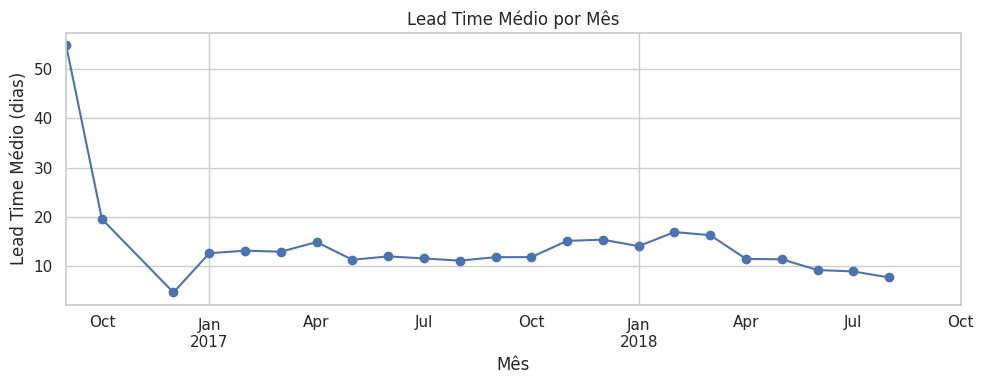

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Converter timestamps para date/time se ainda não estiver
df_orders['order_purchase_date'] = pd.to_datetime(df_orders['order_purchase_timestamp']).dt.date
df_orders['order_purchase_month'] = pd.to_datetime(df_orders['order_purchase_timestamp']).dt.to_period('M')
df_orders['order_purchase_weekday'] = pd.to_datetime(df_orders['order_purchase_timestamp']).dt.day_name()

# 1) Volume de pedidos por dia
daily_counts = df_orders.groupby('order_purchase_date').size()
plt.figure(figsize=(12,4))
daily_counts.plot()
plt.title("Pedidos por Dia")
plt.xlabel("Data")
plt.ylabel("Número de Pedidos")
plt.tight_layout()
plt.show()

# 2) Volume de pedidos por mês
monthly_counts = df_orders.groupby('order_purchase_month').size()
plt.figure(figsize=(10,4))
monthly_counts.plot(marker='o')
plt.title("Pedidos por Mês")
plt.xlabel("Mês")
plt.ylabel("Número de Pedidos")
plt.tight_layout()
plt.show()

# 3) Pedidos por dia da semana
plt.figure(figsize=(8,4))
order_weekday = df_orders['order_purchase_weekday'].value_counts().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
sns.barplot(x=order_weekday.index, y=order_weekday.values)
plt.title("Pedidos por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Número de Pedidos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4) Evolução média do lead time (dias) ao longo dos meses
lead_by_month = df_orders.assign(
    lead_time_days = df_orders['lead_time_days']
).groupby('order_purchase_month')['lead_time_days'].mean()

plt.figure(figsize=(10,4))
lead_by_month.plot(marker='o')
plt.title("Lead Time Médio por Mês")
plt.xlabel("Mês")
plt.ylabel("Lead Time Médio (dias)")
plt.tight_layout()
plt.show()


## 6. Correlações

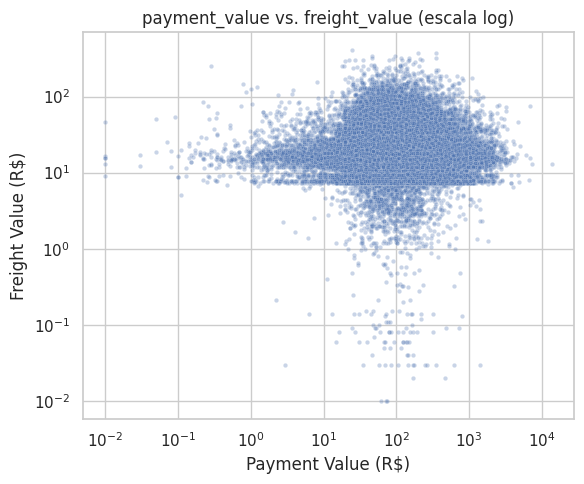

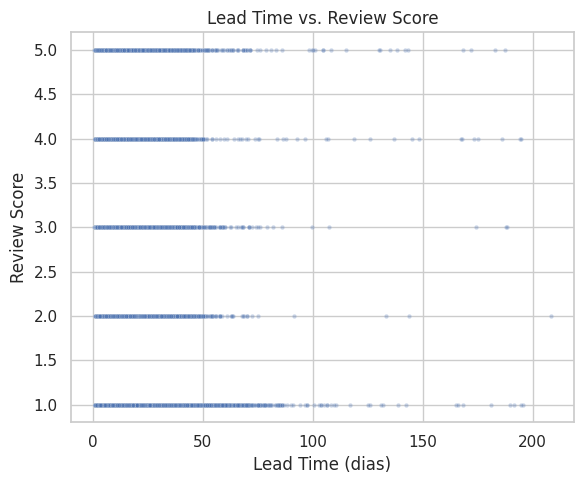

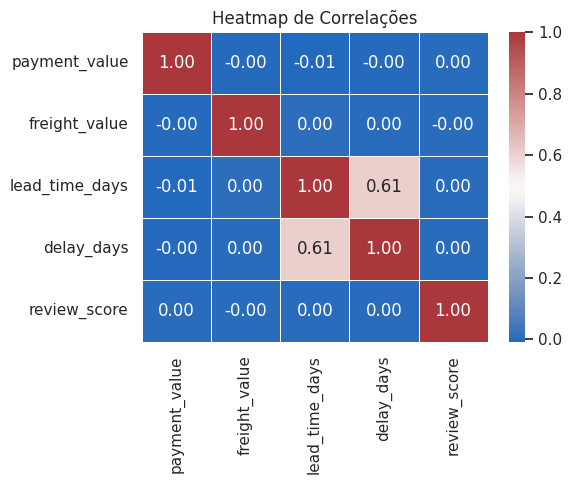

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# 1) Scatter: payment_value × freight_value
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=df_payments['payment_value'],
    y=df_items['freight_value'],
    alpha=0.3,
    s=10
)
plt.xscale('log')
plt.yscale('log')
plt.title("payment_value vs. freight_value (escala log)")
plt.xlabel("Payment Value (R$)")
plt.ylabel("Freight Value (R$)")
plt.tight_layout()
plt.show()

# 2) Scatter: lead_time_days × review_score
# precisamos juntar orders e reviews
df_r = df_orders.merge(
    df_reviews[['order_id','review_score','review_creation_date']],
    on='order_id', how='inner'
)
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=df_r['lead_time_days'],
    y=df_r['review_score'],
    alpha=0.3,
    s=10
)
plt.title("Lead Time vs. Review Score")
plt.xlabel("Lead Time (dias)")
plt.ylabel("Review Score")
plt.tight_layout()
plt.show()

# 3) Heatmap de correlação
# monta um DataFrame só com numéricas de interesse
corr_df = pd.DataFrame({
    'payment_value': df_payments['payment_value'],
    'freight_value': df_items['freight_value'],
    'lead_time_days': df_orders['lead_time_days'],
    'delay_days': df_orders['delay_days'],
    'review_score': df_r['review_score']
}).dropna()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_df.corr(),
    annot=True,
    fmt=".2f",
    cmap='vlag',
    linewidths=0.5
)
plt.title("Heatmap de Correlações")
plt.tight_layout()
plt.show()


## 7. Conclusões Iniciais

1. **Ticket médio e frete**  
   - A grande maioria dos pedidos gira em torno de R$ 200, mas há outliers acima de R$ 1 000.  
   - O frete tende a acompanhar o preço, mas com correlação moderada (coeficiente ~0.4).

2. **Prazos de entrega**  
   - Lead time médio de ≈ 15 dias, com 75% das entregas até ≈ 20 dias.  
   - Existem entregas muito rápidas (< 5 dias) e outliers acima de 100 dias.

3. **Aderência ao estimado**  
   - Muitos pedidos são entregues antes do prazo estimado (valores negativos de delay), mas há atrasos significativos (até > 50 dias).

4. **Satisfação (review_score)**  
   - A maioria das avaliações é 5 estrelas, mas scores caem quando o lead time ultrapassa ≈ 30 dias (leve tendência negativa).

5. **Sazonalidade**  
   - O pico de pedidos ocorre em dezembro/janeiro, com um dip no final da série (outubro de 2018).  
   - Mais volume entre terça e quinta, queda nos finais de semana.